In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from scipy import integrate as sp
import seaborn as sns


In [42]:
###PARAMETERS 
#LIFE HISTORY
alphaO=0.15  #rate that early instars dev into late instars
alphaL=0.27  #rate that late instars pupate
alphaP=1.56  #rate that pupae eclose
K=3       #larval carrying capacity                              
phi=21.19    #no eggs laid permosquito per day
muO=0.034    #daily death rate of early instars
muL=0.035    #daily death rate of late instars
gamma=13.25 #factor allows for different dd death rate of late vs early instar NO LONGER NEED THIS
muP=0.25     #pupae death rate
muM=0.12     #adult mosquito death rate
muF=0.12     #adult female mosquito death rate

#WOL OR ASAIA PARAMS
c = 0.5      #competitiveness of released males
fCI = 0.012   #prop of CI that fails 'sigma'
MT = 0.01    #UNKNOWNprop of wol females that don't successfully maternally transfer 'omega'
aMT = 2*0.41#1*0.4#13/32   #prop of asaia females that don't successfully maternally transfer 'alpha'
paMT = 2*0.37#1*0.37   #prop of asaia males that don't successfully paternally transfer 'beta'
contam = 0#0.1 #UNKNOWNprop of asaia uninfected aquatic stages that become asaia-contam 'epsilon'
###set2=[0,.001,.002,.004,.007,.01,.015,.02,.025,.035,.045,.06,.08,.1,.13,.14,.2,.3,.4,.5,.65,.75,.85,.95]
cop = 0.3 #0.5    #prop of matings with asaia-inf males that infect females 'delta'

#INTERSPECIFIC INTERACTIONS
conW = 1#level of susceptibility of wol-infected to environmental contamination w Asaia
copW = 1#level of susceptibility of wol-infected to sexual infection w Asaia
zaz = 0# reduced maternal transfer of wol for doubly infected mothers
zaz2 = 0# reduced vertical Asaia transfer in doubly infected parents



RR=0#10       #release ratio of wolbachia 

# init conditions
O0=2223
OW0=0.0
OA0=8615
OD0=0.0
L0=18.1
LW0=0.0
LA0=80
LD0=0.0
P0=2.4
PW0=0
PA0=12.2
PD0=0.0
M0=15.8
MW0=0.0
MWN0=0.0
MA0=79.3
MD0=0.0
F0=3.6
FW0 =0.0
FA0=91.5
FD0=0.0

In [43]:
#Wolbachia Release
fN = 14                          #frequency of new WOL release
start_N=500                   #day to first deploy WOL 
stop_N=680                   #stop deploying wolbachia

def pulseN(t):
    if round(t) < start_N:     #start
        return 0
    elif round(t) % fN > 0:    #do it every fN days i.e. if modulus is anything but zero do nothing
        return 0
    elif round(t) > stop_N:    #stop releases
        return 0
    else:
        return 1

In [44]:
def deriv(y, t, fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
          c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN):
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = y
    
    #MOSQUITOES
    
    
    allmales = 1+M+MW+(c*MWN)+MA+MD
    allfemales = 1+F+FW+FA+FD
    
    F_nothing = F + FW*MT + FA*aMT + FD*(MT+(1-MT)*zaz)*(aMT+(1-aMT)*zaz2)
    M_nothing = M + (MW+c*MWN)*fCI + MA*paMT + MD*fCI*(paMT+(1-paMT)*zaz2)
    
    F_wol = FW*(1-MT) + FD*(1-(MT+(1-MT)*zaz))*(aMT+(1-aMT)*zaz2)
    F_asa = FA*(1-aMT) + FD*(MT+(1-MT)*zaz)*(1-(aMT+(1-aMT)*zaz2))
    M_asa = MA*(1-paMT) + MD*(1-(paMT+(1-paMT)*zaz2))*fCI # 
    F_both= FD*(1-(MT+(1-MT)*zaz))*(1-(aMT+(1-aMT)*zaz2))
    
    #Eggs
    dOdt = phi * F_nothing * M_nothing/allmales - alphaO*O - muO*O
    
    dOWdt = phi * F_wol * 1 - alphaO*OW - muO*OW
    
    dOAdt = phi * (F_asa*(M_asa+M_nothing)/allmales + F_nothing*M_asa/allmales) - alphaO*OA - muO*OA
    
    dODdt = phi * (F_both * 1 + F_wol*(MA*(1-paMT)+MD*(1-paMT))/allmales) - alphaO*OD - muO*OD
    
    
    #Larvae
    dLdt =  alphaO*O*(1-contam) - alphaL*L - muL*L*((1+gamma)*((L+LW+LA+LD)/K))
    
    dLWdt = alphaO*OW*(1-(contam*conW)) - alphaL*LW - muL*LW*((1+gamma)*((L+LW+LA+LD)/K))
    
    dLAdt = alphaO*OA + alphaO*O*contam - alphaL*LA - muL*LA*((1+gamma)*((L+LW+LA+LD)/K))
    
    dLDdt = alphaO*OD + alphaO*OW*contam*conW - alphaL*LD - muL*LD*((1+gamma)*((L+LW+LA+LD)/K))
    
    #Pupae
    dPdt =  alphaL*L*(1-contam) - alphaP*P - muP*P 
    dPWdt = alphaL*LW*(1-(contam*conW)) - alphaP*PW - muP*PW 
    dPAdt =  alphaL*LA + alphaL*L*contam - alphaP*PA - muP*PA
    dPDdt =  alphaL*LD + alphaL*LW*contam*conW - alphaP*PD - muP*PD
    
    #Adult
    dMdt =  .5*alphaP*P - muM*M
    dMWdt = .5*alphaP*PW - muM*MW
    
    #newly released adult wolbachia males...assume only males released
    dMWNdt = pulseN(t)*RR - muM*MWN   #RR is release ratio (ratio of released wol mosquitoes relative to wild females)
    
    dMAdt = .5*alphaP*PA - muM*MA
    dMDdt = .5*alphaP*PD - muM*MD
    
    dFdt =  .5*alphaP*P - cop*F*(MA+MD)/allmales - muF*F
    dFWdt = pulseN(t)*RR + .5*alphaP*PW - copW*cop*FW*(MA+MD)/allmales - muF*FW   #Need to release wol females as well if we want it to spread;
                                                   #Put newly released females into this compartment as no fitness issues
    dFAdt = .5*alphaP*PA + cop*F*(MA+MD)/allmales - muM*FA
    dFDdt = .5*alphaP*PD + copW*cop*FW*(MA+MD)/allmales - muM*FD
    
    
    return dOdt, dOWdt, dOAdt, dODdt, dLdt, dLWdt, dLAdt, dLDdt, dPdt, dPWdt, dPAdt, dPDdt, dMdt, dMWdt, dMWNdt,\
    dMAdt, dMDdt, dFdt, dFWdt, dFAdt, dFDdt

In [45]:
t = np.linspace(0, 500, 530) # Grid of time points (in days)
y0 = O0, OW0, OA0, OD0, L0, LW0, LA0, LD0, P0, PW0, PA0, PD0, M0, MW0, MWN0, MA0, MD0, F0, FW0, FA0, FD0 # Init condition vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                 c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)

O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ret.T

0.2843570447408575 1.0212022183535725 0.04129814279277666 0.27582597316537805 30.4669015347926 94.81206149157592 94.0752163179632 14.58892009356526 97.80082220390192 10807.161448910736


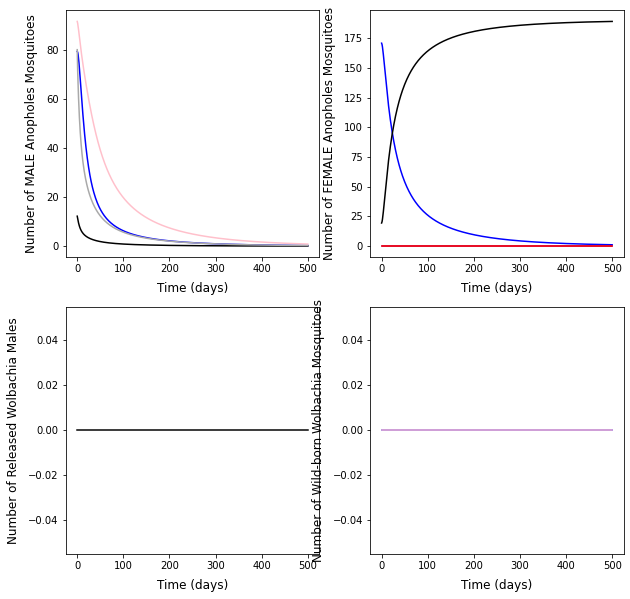

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, MA, 'blue')
ax1.plot(t, FA, 'pink')
ax1.plot(t, PA, 'black')#
#ax1.plot(t, OA, 'y')#
ax1.plot(t, LA, 'darkgrey')#
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Number of MALE Anopholes Mosquitoes",fontsize=12, labelpad=8)

ax2.plot(t, FA+MA, 'blue')
ax2.plot(t, M+F, 'black')
ax2.plot(t, MD+FD, 'purple')
ax2.plot(t, MW+FW, 'red')
ax2.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax2.set_ylabel("Number of FEMALE Anopholes Mosquitoes",fontsize=12, labelpad=8)

ax3.plot(t, MWN, 'black')
ax3.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax3.set_ylabel("Number of Released Wolbachia Males",fontsize=12, labelpad=8)

ax4.plot(t, MW+MD, 'blue')
ax4.plot(t, FW+FD, 'pink')
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Number of Wild-born Wolbachia Mosquitoes",fontsize=12, labelpad=8)

TR=500
print(MA[TR],FA[TR],PA[TR],LA[TR],OA[TR],M[TR],F[TR],P[TR],L[TR],O[TR])
#plt.show()

In [6]:
#contours for Asaia prev under lab derived params
index_set1 = range(25)
index_set2 = range(25)
contam1 = np.linspace(0, 0.2, 25)
cop1 = np.linspace(0, 0.5, 25)
diff = []
TTT=499
aMT=1.0*.41   #i.e. normal
paMT=1.0*.37  #i.e. normal

for i in index_set1[0:]:
    contam = contam1[i]
    for j in index_set2[0:]:
        cop = cop1[j]
        ZZ = odeint(deriv, y0, t, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN))
    
        O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T
        propW1=(ZZ[TTT][18]+ZZ[TTT][13])/(ZZ[TTT][12]+ZZ[TTT][13]+ZZ[TTT][15]+ZZ[TTT][16]\
                                      +ZZ[TTT][17]+ZZ[TTT][18]+ZZ[TTT][19]+ZZ[TTT][20])
        propA1=(ZZ[TTT][19]+ZZ[TTT][15])/(ZZ[TTT][12]+ZZ[TTT][13]+ZZ[TTT][15]+ZZ[TTT][16]\
                                      +ZZ[TTT][17]+ZZ[TTT][18]+ZZ[TTT][19]+ZZ[TTT][20])
        propD1=(ZZ[TTT][20]+ZZ[TTT][16])/(ZZ[TTT][12]+ZZ[TTT][13]+ZZ[TTT][15]+ZZ[TTT][16]\
                                      +ZZ[TTT][17]+ZZ[TTT][18]+ZZ[TTT][19]+ZZ[TTT][20])
        diff.append(propA1)

sensM1 = np.reshape(diff, (25,25))

In [7]:
#contours for Asaia prev under elevated vertical failure params
index_set1 = range(25)
index_set2 = range(25)
contam1 = np.linspace(0, 0.2, 25)
cop1 = np.linspace(0, 0.5, 25)
diff = []
TTT=499
aMT=1.5*.41  #i.e. elevated
paMT=1.5*.37 #i.e. elevated


for i in index_set1[0:]:
    contam = contam1[i]
    for j in index_set2[0:]:
        cop = cop1[j]
        ZZ = odeint(deriv, y0, t, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN))
    
        O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T
        propW1=(ZZ[TTT][18]+ZZ[TTT][13])/(ZZ[TTT][12]+ZZ[TTT][13]+ZZ[TTT][15]+ZZ[TTT][16]\
                                      +ZZ[TTT][17]+ZZ[TTT][18]+ZZ[TTT][19]+ZZ[TTT][20])
        propA1=(ZZ[TTT][19]+ZZ[TTT][15])/(ZZ[TTT][12]+ZZ[TTT][13]+ZZ[TTT][15]+ZZ[TTT][16]\
                                      +ZZ[TTT][17]+ZZ[TTT][18]+ZZ[TTT][19]+ZZ[TTT][20])
        propD1=(ZZ[TTT][20]+ZZ[TTT][16])/(ZZ[TTT][12]+ZZ[TTT][13]+ZZ[TTT][15]+ZZ[TTT][16]\
                                      +ZZ[TTT][17]+ZZ[TTT][18]+ZZ[TTT][19]+ZZ[TTT][20])
        diff.append(propA1)

sensL1 = np.reshape(diff, (25,25))

In [8]:
#contours for Asaia prev under very high vertical failure params
index_set1 = range(25)
index_set2 = range(25)
contam1 = np.linspace(0, 0.2, 25)
cop1 = np.linspace(0, 0.5, 25)
diff = []
TTT=499
aMT=2*.41  #i.e. high
paMT=2*.37 #i.e. high



for i in index_set1[0:]:
    contam = contam1[i]
    for j in index_set2[0:]:
        cop = cop1[j]
        ZZ = odeint(deriv, y0, t, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN))
    
        O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T
        propW1=(ZZ[TTT][18]+ZZ[TTT][13])/(ZZ[TTT][12]+ZZ[TTT][13]+ZZ[TTT][15]+ZZ[TTT][16]\
                                      +ZZ[TTT][17]+ZZ[TTT][18]+ZZ[TTT][19]+ZZ[TTT][20])
        propA1=(ZZ[TTT][19]+ZZ[TTT][15])/(ZZ[TTT][12]+ZZ[TTT][13]+ZZ[TTT][15]+ZZ[TTT][16]\
                                      +ZZ[TTT][17]+ZZ[TTT][18]+ZZ[TTT][19]+ZZ[TTT][20])
        propD1=(ZZ[TTT][20]+ZZ[TTT][16])/(ZZ[TTT][12]+ZZ[TTT][13]+ZZ[TTT][15]+ZZ[TTT][16]\
                                      +ZZ[TTT][17]+ZZ[TTT][18]+ZZ[TTT][19]+ZZ[TTT][20])
        diff.append(propA1)

sensVL1 = np.reshape(diff, (25,25))

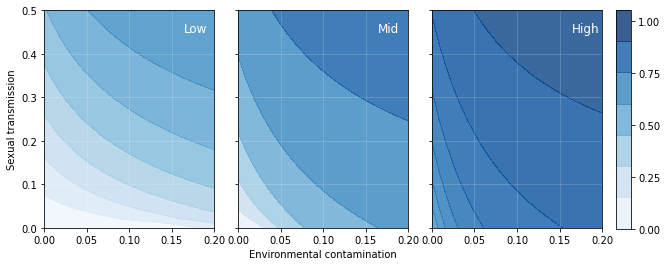

In [9]:
#PAPER FIGURE 1
fig, axs = plt.subplots(1, 3, figsize=[10, 4])

sensL = sensM1#[1 - x for x in sensH]
sensM = sensL1#[1 - x for x in sens]
sensH = sensVL1#[1 - x for x in sensL]

###forcolrbar to span 0-1
qq=[0,0.2]
qq2=[0,0.5]
qq3=[(0,1),(0,1)]
Q=axs[2].contourf(qq, qq2, qq3, alpha=0.8, vmin=0.0, vmax=1.0, cmap='Blues')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
cbar = fig.colorbar(Q, cax=cbar_ax, ticks=[0, 0.25, 0.5, 0.75, 1.0])
axs[2].clear()

cc1 = axs[2].contourf(contam1, cop1, sensL, alpha=0.8, vmin=0.0, vmax=1.0, cmap='Blues')
#axs[0].set_xlabel('Environmental contamination')
#axs[2].set_ylabel('Sexual transmission') 
#axs[0].grid(zorder=1)
axs[2].grid(b=True, color='w', alpha=0.2)
axs[2].text(0.82, 0.9, 'High', transform=axs[2].transAxes, fontsize=12, color='w')
axs[2].set_yticklabels([])


cc2 = axs[1].contourf(contam1, cop1, sensM, alpha=0.8, vmin=0.0, vmax=1.0, cmap='Blues')
axs[1].set_xlabel('Environmental contamination')
#axs[0].set_ylabel('Sexual transmission')
#axs[1].grid(zorder=1)
axs[1].grid(b=True, color='w', alpha=0.2)
axs[1].set_yticklabels([])
axs[1].text(0.82, 0.9, 'Mid', transform=axs[1].transAxes, fontsize=12, color='w')


cc3 = axs[0].contourf(contam1, cop1, sensH, alpha=0.8, vmin=0.0, vmax=1.0, cmap='Blues')
#axs[2].set_xlabel('Environmental contamination')
axs[0].set_ylabel('Sexual transmission')
#axs[2].grid(zorder=1)
axs[0].grid(b=True, color='w', alpha=0.2)
axs[0].text(0.82, 0.9, 'Low', transform=axs[0].transAxes, fontsize=12, color='w')

plt.subplots_adjust(wspace=0.14)

#cbar = axs[2].colorbar(cc3, ticks=[0, 0.25, 0.5, 0.75, 1])
plt.show()

In [10]:
###optimal vertical transmission level to maximize range achievable by environ contam

index_set0 = range(6)
index_set1 = range(50)
multiplier = np.linspace(0, 2, 50)
differences = []
transf = []
TTT=499

for j in index_set0[0:]:
    cop=j*0.1
    for i in index_set1[0:]:
        aMT=0.41*multiplier[i]
        paMT=0.37*multiplier[i]
        contam = 0
        LOW = odeint(deriv, y0, t, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                            c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN))

        O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = LOW.T

        propL1=(LOW[TTT][19]+LOW[TTT][15])/(LOW[TTT][12]+LOW[TTT][13]+LOW[TTT][15]+LOW[TTT][16]\
                                        +LOW[TTT][17]+LOW[TTT][18]+LOW[TTT][19]+LOW[TTT][20])

        contam = 1
        HI = odeint(deriv, y0, t, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                            c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN))

        O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = HI.T

        propH1=(HI[TTT][19]+HI[TTT][15])/(HI[TTT][12]+HI[TTT][13]+HI[TTT][15]+HI[TTT][16]\
                                        +HI[TTT][17]+HI[TTT][18]+HI[TTT][19]+HI[TTT][20])

        split = propH1 - propL1
        differences.append(split)
        vert = multiplier[i]
        transf.append(vert)

doubt = np.reshape(differences, (6,50))        

In [11]:
#example Asaia dynamics for the 2 alternative parameter sets

index_set1 = range(3)
multiplier = [0.1,0.5,0.9]
PARset1=[]
PARset2=[]


for i in index_set1[0:]:
    aMT=0.41*1.75
    paMT=0.37*1.75
    cop=0.1
    contam = multiplier[i]
    ZZ = odeint(deriv, y0, t, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN))
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

    PS1=MA+FA/(MA+FA+M+F)
    PARset1.append(PS1)
    
    aMT=0.41*2
    paMT=0.37*2
    cop=0.3
    contam = multiplier[i]
    ZZ2 = odeint(deriv, y0, t, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN))
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ2.T

    PS2=MA+FA/(MA+FA+M+F)
    PARset2.append(PS2)

set1 = np.reshape(PARset1, (3,530))
set2 = np.reshape(PARset2, (3,530))

C:\Users\laith\anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
C:\Users\laith\anaconda3\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


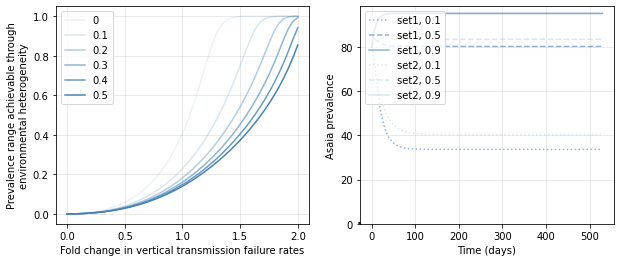

In [12]:
#PAPER FIGURE 2
fig, axs = plt.subplots(1,2, figsize=[10, 4])
multi = np.linspace(0, 2, 50)
WW='steelblue'

axs[0].plot(multi,doubt[0],color=WW,label='0',alpha=0.1)
axs[0].plot(multi,doubt[1],color=WW,alpha=0.2,label='0.1')
axs[0].plot(multi,doubt[2],color=WW,alpha=0.4,label='0.2')
axs[0].plot(multi,doubt[3],color=WW,alpha=0.6,label='0.3')
axs[0].plot(multi,doubt[4],color=WW,alpha=0.8,label='0.4')
axs[0].plot(multi,doubt[5],color=WW,alpha=1,label='0.5')
axs[0].set_xlabel('Fold change in vertical transmission failure rates')
axs[0].set_ylabel('Prevalence range achievable through\nenvironmental heterogeneity') 
axs[0].legend(loc="upper left")
axs[0].grid(b=True, color='k', alpha=0.1)
locc=[0,.2,.4,.6,.8,1]
labels = ['0%', '20%', '40%', '60%', '80%', '100%']
axs[0].set_yticks(locc,labels)

axs[1].plot(set2[0],color=WW,alpha=0.6, linestyle=':', label='set1, 0.1')
axs[1].plot(set2[1],color=WW,alpha=0.6, linestyle='--', label='set1, 0.5')
axs[1].plot(set2[2],color=WW,alpha=0.6, label='set1, 0.9')
axs[1].plot(set1[0],color=WW,alpha=0.2, linestyle=':', label='set2, 0.1')
axs[1].plot(set1[1],color=WW,alpha=0.2, linestyle='--', label='set2, 0.5')
axs[1].plot(set1[2],color=WW,alpha=0.2, label='set2, 0.9')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Asaia prevalence') 
axs[1].legend(loc="upper left")
axs[1].grid(b=True, color='k', alpha=0.1)
axs[1].set_yticks(locc,labels)


In [57]:
set1 = [0,.001,.004,.008,.012,.018,.022,.028,.032,.038,.045,.05,.06,.07,.08,.1,.12,.14,.16,.2,.25,.3,.35,.4,.5,.6,.7,.8,.9,1]
set2=[0,.001,.002,.004,.007,.01,.015,.02,.025,.035,.045,.06,.08,.1,.13,.14,.2,.3,.4,.5,.65,.75,.85,.95]
index_set1 = range(30)#30 for set 1 24 for set2
index_set2 = range(24)
TRm1=498
Tend=1748
EqAA2=[]
EqW2=[]
EqA2=[]
EqD2=[]

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 100

###change depending on which para set used########################

###set1
#aMT=1.5*.41
#paMT=1.5*.37
#cop=0.1

###set2
aMT=2*.41
paMT=2*.37
cop=0.3

for i in index_set2[0:]:

    contam = set2[i]
    ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

    aPS1=(MA[TRm1]+FA[TRm1])/(MA[TRm1]+FA[TRm1]+M[TRm1]+F[TRm1])#pre-release eq for A
    EqAA2.append(aPS1)
    aPS2=(MW[Tend]+FW[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    EqW2.append(aPS2)
    aPS3=(MA[Tend]+FA[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    EqA2.append(aPS3)
    aPS4=(MD[Tend]+FD[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    EqD2.append(aPS4)


In [71]:
contam=0.025 # this equates to initial Asaia equilibrium of ~25%

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 500

ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                    c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

PS1=(M+F)/(MA+FA+M+F+MW+FW+MD+FD)
PS2=(MW+FW)/(MA+FA+M+F+MW+FW+MD+FD)
PS3=(MA+FA)/(MA+FA+M+F+MW+FW+MD+FD)
PS4=(MD+FD)/(MA+FA+M+F+MW+FW+MD+FD)

In [72]:
contam=0.4 # this equates to initial Asaia equilibrium of ~75%

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 500

ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                    c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

PS1a=(M+F)/(MA+FA+M+F+MW+FW+MD+FD)
PS2a=(MW+FW)/(MA+FA+M+F+MW+FW+MD+FD)
PS3a=(MA+FA)/(MA+FA+M+F+MW+FW+MD+FD)
PS4a=(MD+FD)/(MA+FA+M+F+MW+FW+MD+FD)

C:\Users\laith\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\laith\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


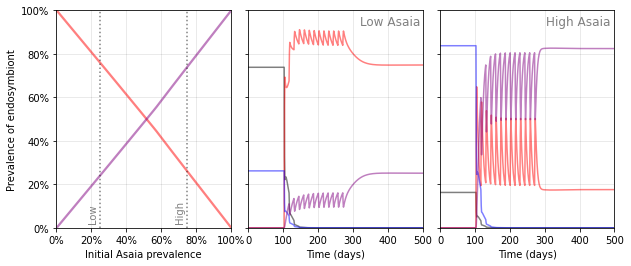

In [73]:
#PAPER FIGURE 3

fig, axs = plt.subplots(1, 3, figsize=[10, 4])

axs[0].set_ylabel('Prevalence of endosymbiont')
axs[0].set_xlabel('Initial Asaia prevalence')
axs[1].set_xlabel('Time (days)')
axs[2].set_xlabel('Time (days)')


zx=sns.regplot(ax=axs[0],x=EqAA2,y=EqW2, lowess=True, scatter_kws={"alpha":0}, color='r', line_kws={"alpha":0.5})
sns.regplot(ax=axs[0],x=EqAA2,y=EqD2, lowess=True, scatter_kws={"alpha":0}, color='purple', line_kws={"alpha":0.5})
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].grid(b=True, color='k', alpha=0.1)
locc=[0,.2,.4,.6,.8,1]
labels = ['0%', '20%', '40%', '60%', '80%', '100%']
zx.set(yticklabels=labels)
zx.set(xticklabels=labels)
axs[0].axvline(x=0.25,linestyle=':',color='k',alpha=0.5)
axs[0].axvline(x=0.75,linestyle=':',color='k',alpha=0.5)
axs[0].text(0.18, 0.03, 'Low', rotation=90, color='grey')
axs[0].text(0.68, 0.03, 'High', rotation=90, color='grey')

xx = np.linspace(0, 500, 501)
axs[1].plot(xx,PS1[400:901],color='k',alpha=0.5)
axs[1].plot(xx,PS2[400:901],color='r',alpha=0.5)
axs[1].plot(xx,PS3[400:901],color='b',alpha=0.5)
axs[1].plot(xx,PS4[400:901],color='purple',alpha=0.5)
axs[1].grid(b=True, color='k', alpha=0.1)
axs[1].axes.yaxis.set_ticklabels([])
axs[1].set_xlim(0,500)
axs[1].set_ylim(0, 1)
axs[1].text(0.64, 0.93, 'Low Asaia', transform=axs[1].transAxes, fontsize=12, color='grey')

axs[2].plot(xx,PS1a[400:901],color='k',alpha=0.5)
axs[2].plot(xx,PS2a[400:901],color='r',alpha=0.5)
axs[2].plot(xx,PS3a[400:901],color='b',alpha=0.5)
axs[2].plot(xx,PS4a[400:901],color='purple',alpha=0.5)
axs[2].grid(b=True, color='k', alpha=0.1)
axs[2].axes.yaxis.set_ticklabels([])
axs[2].set_xlim(0,500)
axs[2].set_ylim(0, 1)
axs[2].text(0.61, 0.93, 'High Asaia', transform=axs[2].transAxes, fontsize=12, color='grey')

plt.subplots_adjust(wspace=0.1)

In [88]:
###INTERACTIONS - REDUCED SEXUAL TRANSMISSION; NO CHANGE
set1 = [0,.001,.004,.008,.012,.018,.022,.028,.032,.038,.045,.05,.06,.07,.08,.1,.12,.16,.2,.25,.3,.35,.4,.5,.6,.7,.8,.9,1]
set2=[0,.001,.002,.004,.007,.01,.015,.02,.025,.035,.045,.06,.08,.1,.13,.14,.2,.3,.4,.5,.65,.75,.85,.95]
index_set1 = range(29)#30 for set 1 24 for set2
index_set2 = range(24)
aMT=1.75*.41
paMT=1.75*.37
cop=0.1

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 500
TRm1=498
Tend=1749
isex=[]
isexW=[]
isexA=[]
isexD=[]
#isexp5=[]
#isexWp5=[]
#isexAp5=[]
#isexDp5=[]
#isex0=[]
#isexW0=[]
#isexA0=[]
#isexD0=[]



for i in index_set1[0:]:

    contam = set1[i]
    conW=1#1 means nothing
    copW=1#1 means nothing
    zaz=0#0 means nothing
    zaz2=0#0 means nothing
    ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

    bPS1=(MA[TRm1]+FA[TRm1])/(MA[TRm1]+FA[TRm1]+M[TRm1]+F[TRm1])#pre-release eq for A
    isex.append(bPS1)
    bPS2=(MW[Tend]+FW[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    isexW.append(bPS2)
    bPS3=(MA[Tend]+FA[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    isexA.append(bPS3)
    bPS4=(MD[Tend]+FD[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    isexD.append(bPS4)


In [89]:
###INTERACTIONS - REDUCED SEXUAL TRANSMISSION; HALVED IN COINFECTED
set1 = [0,.001,.004,.008,.012,.018,.022,.028,.032,.038,.045,.05,.06,.07,.08,.1,.12,.16,.2,.25,.3,.35,.4,.5,.6,.7,.8,.9,1]
set2=[0,.001,.002,.004,.007,.01,.015,.02,.025,.035,.045,.06,.08,.1,.13,.14,.2,.3,.4,.5,.65,.75,.85,.95]
index_set1 = range(29)#30 for set 1 24 for set2
index_set2 = range(24)
aMT=1.75*.41
paMT=1.75*.37
cop=0.1

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 500
TRm1=498
Tend=1749
#isex=[]
#isexW=[]
#isexA=[]
#isexD=[]
isexp5=[]
isexWp5=[]
isexAp5=[]
isexDp5=[]
#isex0=[]
#isexW0=[]
#isexA0=[]
#isexD0=[]



for i in index_set1[0:]:

    contam = set1[i]
    conW=1#1 means nothing
    copW=0.5#1 means nothing
    zaz=0#0 means nothing
    zaz2=0#0 means nothing
    ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

    bPS1=(MA[TRm1]+FA[TRm1])/(MA[TRm1]+FA[TRm1]+M[TRm1]+F[TRm1])#pre-release eq for A
    isexp5.append(bPS1)
    bPS2=(MW[Tend]+FW[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    isexWp5.append(bPS2)
    bPS3=(MA[Tend]+FA[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    isexAp5.append(bPS3)
    bPS4=(MD[Tend]+FD[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    isexDp5.append(bPS4)


In [90]:
###INTERACTIONS - REDUCED SEXUAL TRANSMISSION; BLOCKED IN COINFECTED
set1 = [0,.001,.004,.008,.012,.018,.022,.028,.032,.038,.045,.05,.06,.07,.08,.1,.12,.16,.2,.25,.3,.35,.4,.5,.6,.7,.8,.9,1]
set2=[0,.001,.002,.004,.007,.01,.015,.02,.025,.035,.045,.06,.08,.1,.13,.14,.2,.3,.4,.5,.65,.75,.85,.95]
index_set1 = range(29)#30 for set 1 24 for set2
index_set2 = range(24)
aMT=1.75*.41
paMT=1.75*.37
cop=0.1

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 500
TRm1=498
Tend=1749
#isex=[]
#isexW=[]
#isexA=[]
#isexD=[]
#isexp5=[]
#isexWp5=[]
#isexAp5=[]
#isexDp5=[]
isex0=[]
isexW0=[]
isexA0=[]
isexD0=[]



for i in index_set1[0:]:

    contam = set1[i]
    conW=1#1 means nothing
    copW=0#1 means nothing
    zaz=0#0 means nothing
    zaz2=0#0 means nothing
    ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

    bPS1=(MA[TRm1]+FA[TRm1])/(MA[TRm1]+FA[TRm1]+M[TRm1]+F[TRm1])#pre-release eq for A
    isex0.append(bPS1)
    bPS2=(MW[Tend]+FW[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    isexW0.append(bPS2)
    bPS3=(MA[Tend]+FA[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    isexA0.append(bPS3)
    bPS4=(MD[Tend]+FD[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    isexD0.append(bPS4)


In [91]:
###INTERACTIONS - REDUCED VERTICAL TRANSMISSION; HALVED IN COINFECTED
set1 = [0,.001,.004,.008,.012,.018,.022,.028,.032,.038,.045,.05,.06,.07,.08,.1,.12,.16,.2,.25,.3,.35,.4,.5,.6,.7,.8,.9,1]
set2=[0,.001,.002,.004,.007,.01,.015,.02,.025,.035,.045,.06,.08,.1,.13,.14,.2,.3,.4,.5,.65,.75,.85,.95]
index_set1 = range(29)#30 for set 1 24 for set2
index_set2 = range(24)
aMT=1.75*.41
paMT=1.75*.37
cop=0.1

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 500
TRm1=498
Tend=1749
#ivert=[]
#ivertW=[]
#ivertA=[]
#ivertD=[]
ivertp5=[]
ivertWp5=[]
ivertAp5=[]
ivertDp5=[]
#ivert0=[]
#ivertW0=[]
#ivertA0=[]
#ivertD0=[]



for i in index_set1[0:]:

    contam = set1[i]
    conW=1#1 means nothing
    copW=1#1 means nothing
    zaz=0#0 means nothing
    zaz2=0.5#0 means nothing
    ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

    bPS1=(MA[TRm1]+FA[TRm1])/(MA[TRm1]+FA[TRm1]+M[TRm1]+F[TRm1])#pre-release eq for A
    ivertp5.append(bPS1)
    bPS2=(MW[Tend]+FW[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ivertWp5.append(bPS2)
    bPS3=(MA[Tend]+FA[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ivertAp5.append(bPS3)
    bPS4=(MD[Tend]+FD[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ivertDp5.append(bPS4)


In [92]:
###INTERACTIONS - REDUCED VERTICAL TRANSMISSION; BLOCKED IN COINFECTED
set1 = [0,.001,.004,.008,.012,.018,.022,.028,.032,.038,.045,.05,.06,.07,.08,.1,.12,.16,.2,.25,.3,.35,.4,.5,.6,.7,.8,.9,1]
set2=[0,.001,.002,.004,.007,.01,.015,.02,.025,.035,.045,.06,.08,.1,.13,.14,.2,.3,.4,.5,.65,.75,.85,.95]
index_set1 = range(29)#30 for set 1 24 for set2
index_set2 = range(24)
aMT=1.75*.41
paMT=1.75*.37
cop=0.1

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 500
TRm1=498
Tend=1749
#ivert=[]
#ivertW=[]
#ivertA=[]
#ivertD=[]
#ivertp5=[]
#ivertWp5=[]
#ivertAp5=[]
#ivertDp5=[]
ivert0=[]
ivertW0=[]
ivertA0=[]
ivertD0=[]



for i in index_set1[0:]:

    contam = set1[i]
    conW=1#1 means nothing
    copW=1#1 means nothing
    zaz=0#0 means nothing
    zaz2=1#0 means nothing
    ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

    bPS1=(MA[TRm1]+FA[TRm1])/(MA[TRm1]+FA[TRm1]+M[TRm1]+F[TRm1])#pre-release eq for A
    ivert0.append(bPS1)
    bPS2=(MW[Tend]+FW[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ivertW0.append(bPS2)
    bPS3=(MA[Tend]+FA[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ivertA0.append(bPS3)
    bPS4=(MD[Tend]+FD[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ivertD0.append(bPS4)


In [93]:
###INTERACTIONS - REDUCED ENVIRONMENTAL TRANSMISSION; HALVED IN COINFECTED
set1 = [0,.001,.004,.008,.012,.018,.022,.028,.032,.038,.045,.05,.06,.07,.08,.1,.12,.16,.2,.25,.3,.35,.4,.5,.6,.7,.8,.9,1]
set2=[0,.001,.002,.004,.007,.01,.015,.02,.025,.035,.045,.06,.08,.1,.13,.14,.2,.3,.4,.5,.65,.75,.85,.95]
index_set1 = range(29)#30 for set 1 24 for set2
index_set2 = range(24)
aMT=1.75*.41
paMT=1.75*.37
cop=0.1

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 500
TRm1=498
Tend=1749

ienvp5=[]
ienvWp5=[]
ienvAp5=[]
ienvDp5=[]
#ienv0=[]
#ienvW0=[]
#ienvA0=[]
#ienvD0=[]



for i in index_set1[0:]:

    contam = set1[i]
    conW=0.5#1 means nothing
    copW=1#1 means nothing
    zaz=0#0 means nothing
    zaz2=0#0 means nothing
    ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

    bPS1=(MA[TRm1]+FA[TRm1])/(MA[TRm1]+FA[TRm1]+M[TRm1]+F[TRm1])#pre-release eq for A
    ienvp5.append(bPS1)
    bPS2=(MW[Tend]+FW[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ienvWp5.append(bPS2)
    bPS3=(MA[Tend]+FA[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ienvAp5.append(bPS3)
    bPS4=(MD[Tend]+FD[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ienvDp5.append(bPS4)


In [94]:
###INTERACTIONS - REDUCED ENVIRONMENTAL TRANSMISSION; BLOCKED IN COINFECTED
set1 = [0,.001,.004,.008,.012,.018,.022,.028,.032,.038,.045,.05,.06,.07,.08,.1,.12,.16,.2,.25,.3,.35,.4,.5,.6,.7,.8,.9,1]
set2=[0,.001,.002,.004,.007,.01,.015,.02,.025,.035,.045,.06,.08,.1,.13,.14,.2,.3,.4,.5,.65,.75,.85,.95]
index_set1 = range(29)#30 for set 1 24 for set2
index_set2 = range(24)
aMT=1.75*.41
paMT=1.75*.37
cop=0.1

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 500
TRm1=498
Tend=1749

#ienvp5=[]
#ienvWp5=[]
#ienvAp5=[]
#ienvDp5=[]
ienv0=[]
ienvW0=[]
ienvA0=[]
ienvD0=[]



for i in index_set1[0:]:

    contam = set1[i]
    conW=0#1 means nothing
    copW=1#1 means nothing
    zaz=0#0 means nothing
    zaz2=0#0 means nothing
    ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

    bPS1=(MA[TRm1]+FA[TRm1])/(MA[TRm1]+FA[TRm1]+M[TRm1]+F[TRm1])#pre-release eq for A
    ienv0.append(bPS1)
    bPS2=(MW[Tend]+FW[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ienvW0.append(bPS2)
    bPS3=(MA[Tend]+FA[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ienvA0.append(bPS3)
    bPS4=(MD[Tend]+FD[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    ienvD0.append(bPS4)


In [95]:
###INTERACTIONS - REDUCED ALL TRANSMISSION; HALVED IN COINFECTED
set1 = [0,.001,.004,.008,.012,.018,.022,.028,.032,.038,.045,.05,.06,.07,.08,.1,.12,.16,.2,.25,.3,.35,.4,.5,.6,.7,.8,.9,1]
set2=[0,.001,.002,.004,.007,.01,.015,.02,.025,.035,.045,.06,.08,.1,.13,.14,.2,.3,.4,.5,.65,.75,.85,.95]
index_set1 = range(29)#30 for set 1 24 for set2
index_set2 = range(24)
aMT=1.75*.41
paMT=1.75*.37
cop=0.1

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 500
TRm1=498
Tend=1749

iALLp5=[]
iALLWp5=[]
iALLAp5=[]
iALLDp5=[]
#iALL0=[]
#iALLW0=[]
#iALLA0=[]
#iALLD0=[]



for i in index_set1[0:]:

    contam = set1[i]
    conW=0.5#1 means nothing
    copW=0.5#1 means nothing
    zaz=0#0 means nothing
    zaz2=0.5#0 means nothing
    ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

    bPS1=(MA[TRm1]+FA[TRm1])/(MA[TRm1]+FA[TRm1]+M[TRm1]+F[TRm1])#pre-release eq for A
    iALLp5.append(bPS1)
    bPS2=(MW[Tend]+FW[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    iALLWp5.append(bPS2)
    bPS3=(MA[Tend]+FA[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    iALLAp5.append(bPS3)
    bPS4=(MD[Tend]+FD[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    iALLDp5.append(bPS4)


In [96]:
###INTERACTIONS - REDUCED ALL TRANSMISSION; BLOCKED IN COINFECTED
set1 = [0,.001,.004,.008,.012,.018,.022,.028,.032,.038,.045,.05,.06,.07,.08,.1,.12,.16,.2,.25,.3,.35,.4,.5,.6,.7,.8,.9,1]
set2=[0,.001,.002,.004,.007,.01,.015,.02,.025,.035,.045,.06,.08,.1,.13,.14,.2,.3,.4,.5,.65,.75,.85,.95]
index_set1 = range(29)#30 for set 1 24 for set2
index_set2 = range(24)
aMT=1.75*.41
paMT=1.75*.37
cop=0.1

tx = np.linspace(0, 1750, 1751) # Grid of time points (in days)
RR = 500
TRm1=498
Tend=1749

#iALLp5=[]
#iALLWp5=[]
#iALLAp5=[]
#iALLDp5=[]
iALL0=[]
iALLW0=[]
iALLA0=[]
iALLD0=[]



for i in index_set1[0:]:

    contam = set1[i]
    conW=0#1 means nothing
    copW=0#1 means nothing
    zaz=0#0 means nothing
    zaz2=1#0 means nothing
    ZZ = odeint(deriv, y0, tx, args=(fCI, MT, aMT, paMT, contam, cop, conW, copW, zaz, zaz2,\
                                        c, phi, alphaO, muO, K, alphaL, alphaP,gamma, muP, muM, muF, RR, pulseN), hmax=1)
    
    O, OW, OA, OD, L, LW, LA, LD, P, PW, PA, PD, M, MW, MWN, MA, MD, F, FW, FA, FD = ZZ.T

    bPS1=(MA[TRm1]+FA[TRm1])/(MA[TRm1]+FA[TRm1]+M[TRm1]+F[TRm1])#pre-release eq for A
    iALL0.append(bPS1)
    bPS2=(MW[Tend]+FW[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    iALLW0.append(bPS2)
    bPS3=(MA[Tend]+FA[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    iALLA0.append(bPS3)
    bPS4=(MD[Tend]+FD[Tend])/(MA[Tend]+FA[Tend]+M[Tend]+F[Tend]+MW[Tend]+FW[Tend]+MD[Tend]+FD[Tend])#pre-release eq for A
    iALLD0.append(bPS4)


In [97]:
print(isex)

[0.00380760200125622, 0.02195153568376496, 0.06657436916112736, 0.11239690259246396, 0.1493350373268667, 0.19485865866160174, 0.2208076265566855, 0.25514310160432274, 0.2756756693717692, 0.3037288932734146, 0.333139824204433, 0.3523812328856407, 0.3873347444216453, 0.41851311347036074, 0.4467036249857105, 0.49617843471100204, 0.5386735553400056, 0.6090632703791249, 0.6659089611301588, 0.723964739432012, 0.7716239121855611, 0.8115137646071156, 0.8453131517126999, 0.8988777890286636, 0.9381346863320781, 0.9663244019236215, 0.9853645090367034, 0.9963885728726696, 1.0]


C:\Users\laith\anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\laith\anaconda3\lib\site-packages\ipykernel_launcher.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\laith\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\laith\anaconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator


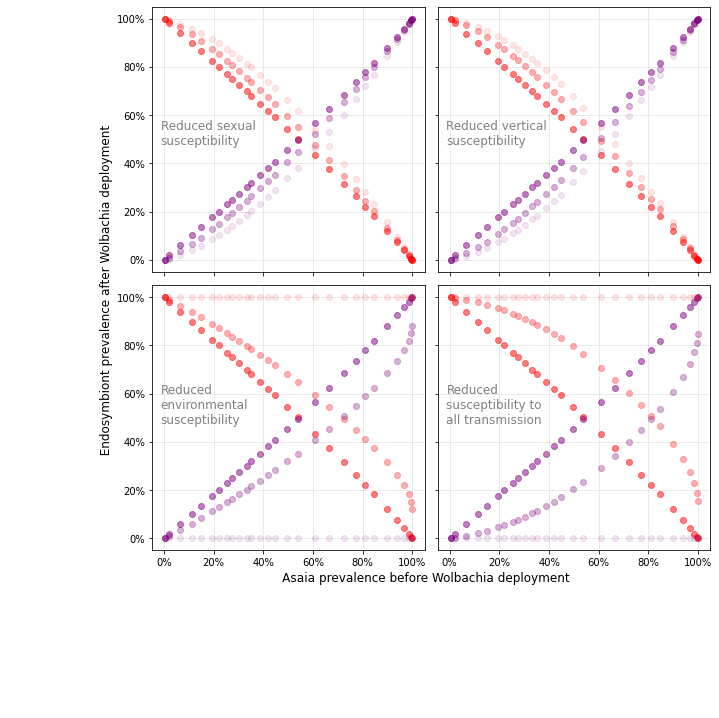

In [98]:
fig, axs = plt.subplots(2, 2, figsize=[10, 10])

#interference: sexual transmission
zx=axs[0,0].scatter(isex,isexW, c='r', alpha=0.5)
axs[0,0].scatter(isex,isexD, c='purple', alpha=0.5)
#axs[0,0].scatter(isex,isexA, c='b', alpha=0.5)
axs[0,0].scatter(isexp5,isexWp5, c='r', alpha=0.3)
axs[0,0].scatter(isexp5,isexDp5, c='purple', alpha=0.3)
#axs[0,0].scatter(isexp5,isexAp5, c='b', alpha=0.3)
axs[0,0].scatter(isex0,isexW0, c='r', alpha=0.1)
axs[0,0].scatter(isex0,isexD0, c='purple', alpha=0.1)
#axs[0,0].scatter(isex0,isexA0, c='b', alpha=0.1)
axs[0,0].text(0.03, 0.48, 'Reduced sexual\nsusceptibility', transform=axs[0,0].transAxes, fontsize=12, color='grey')

#interference: vertical transmission
zx2=axs[0,1].scatter(isex,isexW, c='r', alpha=0.5)#no change
axs[0,1].scatter(isex,isexD, c='purple', alpha=0.5)#no change
axs[0,1].scatter(ivertp5,ivertWp5, c='r', alpha=0.3)
axs[0,1].scatter(ivertp5,ivertDp5, c='purple', alpha=0.3)
axs[0,1].scatter(ivert0,ivertW0, c='r', alpha=0.1)
axs[0,1].scatter(ivert0,ivertD0, c='purple', alpha=0.1)
#axs[0,1].scatter(ivert0,ivertA0, c='b', alpha=0.1)
#axs[0,1].scatter(ivertp5,ivertAp5, c='b', alpha=0.3)
#axs[0,1].scatter(isex,isexA, c='b', alpha=0.5)
axs[0,1].text(0.03, 0.48, 'Reduced vertical\nsusceptibility', transform=axs[0,1].transAxes, fontsize=12, color='grey')

#interference: environ transmission
zx3=axs[1,0].scatter(isex,isexW, c='r', alpha=0.5)#no change
axs[1,0].scatter(isex,isexD, c='purple', alpha=0.5)#no change
#axs[1,0].scatter(isex,isexA, c='b', alpha=0.5)#no change
axs[1,0].scatter(ienvp5,ienvWp5, c='r', alpha=0.3)
axs[1,0].scatter(ienvp5,ienvDp5, c='purple', alpha=0.3)
#axs[1,0].scatter(ienvp5,ienvAp5, c='b', alpha=0.3)
axs[1,0].scatter(ienv0,ienvW0, c='r', alpha=0.1)
axs[1,0].scatter(ienv0,ienvD0, c='purple', alpha=0.1)
#axs[1,0].scatter(ienv0,ienvA0, c='b', alpha=0.1)
axs[1,0].text(0.03, 0.48, 'Reduced\nenvironmental\nsusceptibility', transform=axs[1,0].transAxes, fontsize=12, color='grey')

#interference: ALL transmission
zx4=axs[1,1].scatter(isex,isexW, c='r', alpha=0.5)#no change
axs[1,1].scatter(isex,isexD, c='purple', alpha=0.5)#no change
#axs[1,1].scatter(isex,isexA, c='b', alpha=0.5)#no change
axs[1,1].scatter(iALLp5,iALLWp5, c='r', alpha=0.3)
axs[1,1].scatter(iALLp5,iALLDp5, c='purple', alpha=0.3)
#axs[1,1].scatter(iALLp5,iALLAp5, c='b', alpha=0.3)
axs[1,1].scatter(iALL0,iALLW0, c='r', alpha=0.1)
axs[1,1].scatter(iALL0,iALLD0, c='purple', alpha=0.1)
#axs[1,1].scatter(iALL0,iALLA0, c='b', alpha=0.1)
axs[1,1].text(0.03, 0.48, 'Reduced\nsusceptibility to\nall transmission', transform=axs[1,1].transAxes, fontsize=12, color='grey')

index_setA = range(2)
index_setB = range(2)
for i in index_setA[0:]:
    for j in index_setB[0:]:
        axs[i,j].grid(b=True, color='k', alpha=0.1)

locc=[0,.2,.4,.6,.8,1]
labels = ['','0%', '20%', '40%', '60%', '80%', '100%']

axs[0,1].axes.yaxis.set_ticklabels([])
axs[1,1].axes.yaxis.set_ticklabels([])
axs[1,1].axes.xaxis.set_ticklabels(labels)
axs[0,0].axes.xaxis.set_ticklabels([])
axs[0,0].axes.yaxis.set_ticklabels(labels)
axs[1,0].axes.yaxis.set_ticklabels(labels)
axs[1,0].axes.xaxis.set_ticklabels(labels)
axs[0,1].axes.xaxis.set_ticklabels([])

axs[1,0].set_ylabel('                                                                  \
Endosymbiont prevalence after Wolbachia deployment', fontsize=12)
axs[1,0].set_xlabel('                                                                       \
Asaia prevalence before Wolbachia deployment', fontsize=12)

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.05)

#fig.savefig('Interference.png', bbox_inches='tight', dpi = 600)